In [1]:
import os
from argparse import Namespace
from collections import Counter
import json
import re
import string

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm_notebook
from math import log

In [2]:
from nltk.translate import bleu_score
import seaborn as sns
import matplotlib.pyplot as plt
from alignment_utils import tokenize_mr, tokenize_mr_upper
from data_processing import Delexicalizer

delexicalizer = Delexicalizer("partial", ["name", "near", "food"])

chencherry = bleu_score.SmoothingFunction()

In [3]:
def beam_search_decoder(data, k):
	sequences = [[list(), 1.0]]
	# walk over each step in sequence
	for row in data:
		all_candidates = list()
		# expand each current candidate
		for i in range(len(sequences)):
			seq, score = sequences[i]
			for j in range(len(row)):
				candidate = [seq + [j], score * -log(row[j])]
				all_candidates.append(candidate)
		# order all candidates by score
		ordered = sorted(all_candidates, key=lambda tup:tup[1])
		# select k best
		sequences = ordered[:k]
	return sequences

In [4]:
def sentence_from_indices(indices, vocab, strict=True, return_string=True):
    ignore_indices = set([vocab.mask_index, vocab.begin_seq_index, vocab.end_seq_index])
    out = []
    for index in indices:
        if index == vocab.begin_seq_index and strict:
            continue
        elif index == vocab.end_seq_index and strict:
            break
        else:
            out.append(vocab.lookup_index(index))
    if return_string:
        return " ".join(out)
    else:
        return out
    
class NMTSampler:
    def __init__(self, vectorizer, model):
        self.vectorizer = vectorizer
        self.model = model
    
    def apply_to_batch(self, batch_dict):
        self._last_batch = batch_dict
        
        y_pred = self.model(x_source=batch_dict['x_source'], 
                            x_source_lengths=batch_dict['x_source_length'], 
                            # To fix the sampling probability to 0
                            target_sequence=batch_dict['x_target'],
                            sample_probability=1.0)
        print(y_pred.shape)
        self._last_batch['y_pred'] = y_pred
        attention_batched = np.stack(self.model.decoder._cached_p_attn).transpose(1, 0, 2)
        self._last_batch['attention'] = attention_batched
        
    def _get_source_sentence(self, index, return_string=True):
        indices = self._last_batch['x_source'][index].cpu().detach().numpy()
        vocab = self.vectorizer.source_vocab
        return sentence_from_indices(indices, vocab, return_string=return_string)
    
    def _get_reference_sentence(self, index, return_string=True):
        indices = self._last_batch['y_target'][index].cpu().detach().numpy()
        vocab = self.vectorizer.target_vocab
        return sentence_from_indices(indices, vocab, return_string=return_string)
    
    def _get_gt_mrs(self, index):
        inp_mr = self._last_batch['inp_gt'][index]
        return inp_mr
    
    def _get_gt_ref(self, index):
        ref_gt = self._last_batch['ref_gt'][index]
        return ref_gt
    
    def _get_reranker_result(self, index):
        pass
    
    def _get_sampled_sentence(self, index, return_string=True):
        prob_res = torch.nn.functional.softmax(self._last_batch['y_pred'], dim=2)
        sentece_probs = prob_res[index].cpu().detach().numpy()
        
        top_sequences = beam_search_decoder(sentece_probs, 3)
        
        sentence_indices = top_sequences[0][0]
        print("Making a prediction {}".format(index))
        
        #Old code
#         # Here the beam search and the reranker should be included
#         prob_res = torch.nn.functional.softmax(self._last_batch['y_pred'], dim=2)
        
#         # Maximize the results, so the indices are applied
#         #_, all_indices = torch.max(self._last_batch['y_pred'], dim=2)
        
#         #Use softmax before maximization
#         _, all_indices = torch.max(prob_res, dim=2)

#         sentence_indices = all_indices[index].cpu().detach().numpy()
        vocab = self.vectorizer.target_vocab
        return sentence_from_indices(sentence_indices, vocab, return_string=return_string)

    def get_ith_item(self, index, return_string=True):
        sampled_sentence = self._get_sampled_sentence(index, return_string=return_string)
        gt_mrs = self._get_gt_mrs(index)
        ref_gt = self._get_gt_ref(index)
        
        sampled_normalized = delexicalizer.reverse_delexicalize_sample(gt_mrs, " ".join(sampled_sentence))
        
        output = {"source": self._get_source_sentence(index, return_string=return_string), 
                  "reference": self._get_reference_sentence(index, return_string=return_string), 
                  "sampled": sampled_sentence,
                  "attention": self._last_batch['attention'][index],
                  "sampled_normalized":sampled_normalized,
                  "reference_gt":ref_gt,
                  "mrs_gt":gt_mrs,
                  "y_target": self._last_batch['y_target'][index]
                 }
        
        reference = output['reference']
        hypothesis = output['sampled']
        
        if not return_string:
            reference = " ".join(reference)
            hypothesis = " ".join(hypothesis)
        
        output['bleu-4'] = bleu_score.sentence_bleu(references=[reference],
                                                    hypothesis=hypothesis,
                                                    smoothing_function=chencherry.method1)
        
        return output

In [5]:
args = Namespace(dataset_csv="data/inp_and_gt.csv",
                 vectorizer_file="vectorizer.json",
                 model_state_file="model.pth",
                 save_dir="data/model_storage/",
                 reload_from_files=False,
                 expand_filepaths_to_save_dir=True,
                 cuda=True,
                 seed=1337,
                 learning_rate=5e-4,
                 batch_size=32,
                 num_epochs=100,
                 early_stopping_criteria=5,              
                 source_embedding_size=24, 
                 target_embedding_size=24,
                 encoding_size=32,
                 catch_keyboard_interrupt=True)

In [6]:
from encoders import NMTEncoder
from decoders import NMTDecoder
from data_loader import NMTDataset, generate_nmt_batches
from models import NMTModel
# Check CUDA
if not torch.cuda.is_available():
    args.cuda = False

args.device = torch.device("cuda" if args.cuda else "cpu")

dataset = NMTDataset.load_dataset_and_load_vectorizer("data/inp_and_gt.csv",
                                                          "data/model_storage/vectorizer.json")
vectorizer = dataset.get_vectorizer()
model = NMTModel(source_vocab_size=len(vectorizer.source_vocab), 
                 source_embedding_size=args.source_embedding_size, 
                 target_vocab_size=len(vectorizer.target_vocab),
                 target_embedding_size=args.target_embedding_size, 
                 encoding_size=args.encoding_size,
                 target_bos_index=vectorizer.target_vocab.begin_seq_index)

model.load_state_dict(torch.load(args.save_dir+args.model_state_file))
model.eval().to(args.device)

sampler = NMTSampler(vectorizer, model)

dataset.set_split('val')

batch_generator = generate_nmt_batches(dataset, 
                                       batch_size=args.batch_size, 
                                       device=args.device,
                                       shuffle=False)

#Contains the samples for the current batch
batch_dict = next(batch_generator)

model = model.eval().to(args.device)
sampler = NMTSampler(vectorizer, model)

# Apply the sampler to the batch
sampler.apply_to_batch(batch_dict)

['name[Alimentum], area[city centre], familyFriendly[no]', 'name[Alimentum], area[city centre], familyFriendly[no]', 'name[Alimentum], area[city centre], familyFriendly[no]', 'name[Alimentum], area[city centre], familyFriendly[no]', 'name[Alimentum], area[city centre], familyFriendly[no]', 'name[Alimentum], area[city centre], familyFriendly[no]', 'name[Alimentum], area[city centre], familyFriendly[no], near[Burger King]', 'name[Alimentum], area[city centre], familyFriendly[no], near[Burger King]', 'name[Alimentum], area[city centre], familyFriendly[no], near[Burger King]', 'name[Alimentum], area[city centre], familyFriendly[no], near[Burger King]', 'name[Alimentum], area[city centre], familyFriendly[no], near[Burger King]', 'name[Alimentum], area[city centre], familyFriendly[no], near[Burger King]', 'name[Alimentum], area[city centre], familyFriendly[yes]', 'name[Alimentum], area[city centre], familyFriendly[yes]', 'name[Alimentum], area[city centre], familyFriendly[yes]', 'name[Alimen

In [7]:
all_results = []
#args.batch_size
for i in range(3):
    all_results.append(sampler.get_ith_item(i, False))

Making a prediction 0
Making a prediction 1
Making a prediction 2


In [16]:
len(all_results)
len(vectorizer.target_vocab)

2894

In [23]:
top_results = [x for x in all_results if x['bleu-4']>0.5]

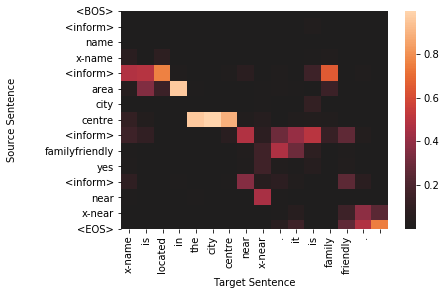

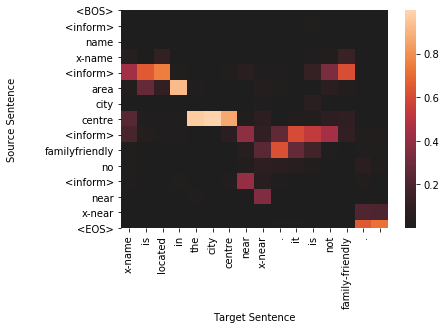

In [24]:
for sample in top_results:
    plt.figure()
    target_len = len(sample['sampled'])
    source_len = len(sample['source'])

    attention_matrix = sample['attention'][:target_len, :source_len+2].transpose()#[::-1]
    ax = sns.heatmap(attention_matrix, center=0.0)
    ylabs = ["<BOS>"]+sample['source']+["<EOS>"]
    #ylabs = sample['source']
    #ylabs = ylabs[::-1]
    ax.set_yticklabels(ylabs, rotation=0)
    ax.set_xticklabels(sample['sampled'], rotation=90)
    ax.set_xlabel("Target Sentence")
    ax.set_ylabel("Source Sentence\n\n")

In [8]:
for result in all_results[:3]:
    print("MR GT: ")
    print(result["mrs_gt"])
    print("------------------")
    print("Input MR: ")
    print(result["source"])
    print("-------------------------")
    print("Reference ground truth: ")
    print(result["reference_gt"])
    print("---------------------------")
    print("Sampled no delexicalization: ")
    print(result["sampled_normalized"])
    print("---------------------------")
    print("Sampled with delexicalization: ")
    print(" ".join(result["sampled"]))
    print("---------------------------")
    print(result["y_target"])
    print("############################")


MR GT: 
name[Alimentum], area[city centre], familyFriendly[yes], near[Burger King]
------------------
Input MR: 
['<inform>', 'name', 'x-name', '<inform>', 'area', 'city', 'centre', '<inform>', 'familyfriendly', 'yes', '<inform>', 'near', 'x-near']
-------------------------
Reference ground truth: 
Located Burger King in the city centre , Alimentum is family-friendly . 
---------------------------
Sampled no delexicalization: 
Alimentum is a kid friendly restaurant located in Burger King in the city centre . 
---------------------------
Sampled with delexicalization: 
x-name is a kid friendly restaurant located in x-near in the city centre . 
---------------------------
tensor([48,  7, 56, 27, 83, 84, 21,  4, 34, 82, 13, 18,  3,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
 

In [19]:
def get_source_sentence(vectorizer, batch_dict, index):
    indices = batch_dict['x_source'][index].cpu().data.numpy()
    vocab = vectorizer.source_vocab
    return sentence_from_indices(indices, vocab)

def get_true_sentence(vectorizer, batch_dict, index):
    return sentence_from_indices(batch_dict['y_target'].cpu().data.numpy()[index], vectorizer.target_vocab)
    
def get_sampled_sentence(vectorizer, batch_dict, index):
    y_pred = model(x_source=batch_dict['x_source'], 
                   x_source_lengths=batch_dict['x_source_length'], 
                   target_sequence=batch_dict['x_target'], 
                   sample_probability=1.0)
    return sentence_from_indices(torch.max(y_pred, dim=2)[1].cpu().data.numpy()[index], vectorizer.target_vocab)

def get_all_sentences(vectorizer, batch_dict, index):
    return {"source": get_source_sentence(vectorizer, batch_dict, index), 
            "truth": get_true_sentence(vectorizer, batch_dict, index), 
            "sampled": get_sampled_sentence(vectorizer, batch_dict, index)}
    
def sentence_from_indices(indices, vocab, strict=True):
    ignore_indices = set([vocab.mask_index, vocab.begin_seq_index, vocab.end_seq_index])
    out = []
    for index in indices:
        if index == vocab.begin_seq_index and strict:
            continue
        elif index == vocab.end_seq_index and strict:
            return " ".join(out)
        else:
            out.append(vocab.lookup_index(index))
    return " ".join(out)

results = get_all_sentences(vectorizer, batch_dict, 30)
results

{'source': '<inform> name x-name <inform> area riverside <inform> familyfriendly yes',
 'truth': 'the x-name is in the riverside area . it is a family friendly place . ',
 'sampled': 'x-name is a friendly , is located in the riverside area . '}